## 人工神经网络初步
作者：[@寒小阳](blog.csdn.net/han_xiaoyang)
日期：2016年6月

人工神经网络其实在很久以前就被提出来了，苦于当时没有足够强大的硬件(比如现在铺天盖地的GPU)去支撑理论的实践，数据的支撑也不够，因此消停了非常长的时间。<br><br>
当然，它的热度在近两年被推到了一个近乎极端的状态，似乎是个好点的实验室，是个大型点的互联网公司，不说自己会点深度学习和神经网络都不好意思说自己是这个圈子里混的。当然，媒体的炒作是一方面啦，但是神经网络确实在近期的一些任务中表现出了非常强势的优势。<br><br>
比如在很多分类问题中，样本是不可线性切分的，那特征的处理就尤为重要了，有意思的是，这正是神经网络所擅长的，在每一次的前向计算过程中，就在自动地做feature engineering，而到达softmax层的时候，其实构造出来的feature空间里，样本已经是能近似线性切分的了，于是三下五除二把其他分类器远远甩在后面了。<br><br>
背景废话了一大堆，咱们来具体看看，简单的人工神经网络是怎么样对样本点做非线性切分的。

/Users/davy/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


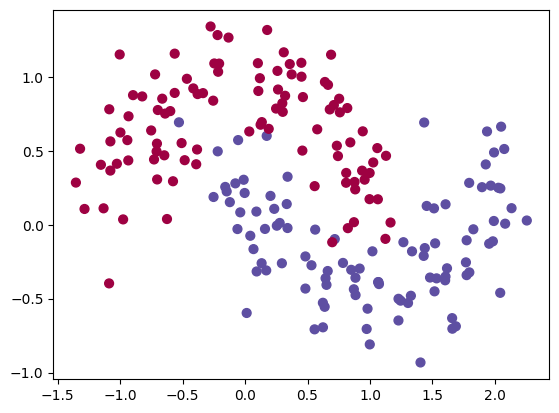

In [1]:
import numpy as np
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
# 手动生成一个随机的平面点分布，并画出来
np.random.seed(0)
X, y = make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)
plt.show()

画出了这样一幅图
![](http://d3kbpzbmcynnmx.cloudfront.net/wp-content/uploads/2015/09/nn-from-scratch-dataset.png)

### 咱们定义一个函数用来画我们分类结果的决策边界（也就是分界线）

In [2]:
# 咱们先顶一个一个函数来画决策边界
def plot_decision_boundary(pred_func):

    # 设定最大最小值，附加一点点边缘填充
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # 用预测函数预测一下
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # 然后画出图
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

### 我们先用传统的逻辑回归来做一下分类，并画出判定边界

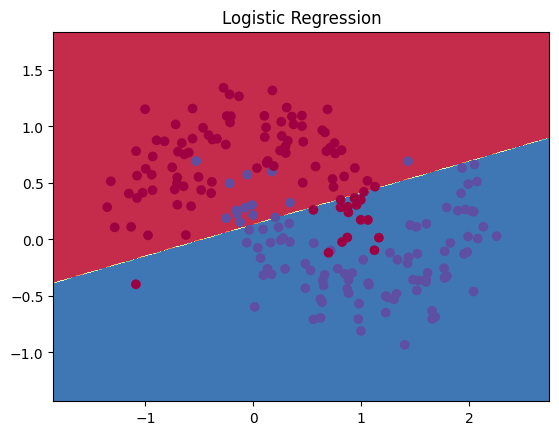

In [3]:
from sklearn.linear_model import LogisticRegressionCV
#咱们先来瞄一眼逻辑斯特回归对于它的分类效果
clf = LogisticRegressionCV()
clf.fit(X, y)
 
# 画一下决策边界
plot_decision_boundary(lambda x: clf.predict(x))
plt.title("Logistic Regression")
plt.show()

咱们看到下面这样的结果<br>
很好理解对吧，因为线性切分，决策边界是直线，这条直线只能尽量让某一类点落在某一侧，但是永远做不到真的完全切分
![](http://d3kbpzbmcynnmx.cloudfront.net/wp-content/uploads/2015/09/nn-from-scratch-lr-decision-boundary.png)

## 咱们来试一个简单的人工神经网络
![](http://www.wildml.com/wp-content/uploads/2015/09/nn-from-scratch-3-layer-network.png)
![](http://s0.wp.com/latex.php?zoom=2&latex=%5Cbegin%7Baligned%7D++z_1+%26+%3D+xW_1+%2B+b_1+%5C%5C++a_1+%26+%3D+%5Ctanh%28z_1%29+%5C%5C++z_2+%26+%3D+a_1W_2+%2B+b_2+%5C%5C++a_2+%26+%3D+%5Chat%7By%7D+%3D+%5Cmathrm%7Bsoftmax%7D%28z_2%29++%5Cend%7Baligned%7D&bg=ffffff&fg=000&s=0)
![](http://s0.wp.com/latex.php?zoom=2&latex=W_1+%5Cin+%5Cmathbb%7BR%7D%5E%7B2%5Ctimes500%7D&bg=ffffff&fg=000&s=0)
![](http://s0.wp.com/latex.php?zoom=2&latex=b_1+%5Cin+%5Cmathbb%7BR%7D%5E%7B500%7D&bg=ffffff&fg=000&s=0)
![](http://s0.wp.com/latex.php?zoom=2&latex=W_2+%5Cin+%5Cmathbb%7BR%7D%5E%7B500%5Ctimes2%7D&bg=ffffff&fg=000&s=0)
![](http://s0.wp.com/latex.php?zoom=2&latex=b_2+%5Cin+%5Cmathbb%7BR%7D%5E%7B2%7D&bg=ffffff&fg=000&s=0)

## 这是一个分类问题，因此我们用softmax分类器，并且用交叉熵损失作为损失函数
![](http://s0.wp.com/latex.php?zoom=2&latex=%5Cbegin%7Baligned%7D++L%28y%2C%5Chat%7By%7D%29+%3D+-+%5Cfrac%7B1%7D%7BN%7D+%5Csum_%7Bn+%5Cin+N%7D+%5Csum_%7Bi+%5Cin+C%7D+y_%7Bn%2Ci%7D+%5Clog%5Chat%7By%7D_%7Bn%2Ci%7D++%5Cend%7Baligned%7D++&bg=ffffff&fg=000&s=0)

## BP计算梯度以便使用(随机)梯度下降
![](http://s0.wp.com/latex.php?zoom=2&latex=%5Cbegin%7Baligned%7D++%26+%5Cdelta_3+%3D+%5Chat%7By%7D+-+y+%5C%5C++%26+%5Cdelta_2+%3D+%281+-+%5Ctanh%5E2+z_1%29+%5Ccirc+%5Cdelta_3W_2%5ET+%5C%5C++%26+%5Cfrac%7B%5Cpartial%7BL%7D%7D%7B%5Cpartial%7BW_2%7D%7D+%3D+a_1%5ET+%5Cdelta_3+%5C%5C++%26+%5Cfrac%7B%5Cpartial%7BL%7D%7D%7B%5Cpartial%7Bb_2%7D%7D+%3D+%5Cdelta_3%5C%5C++%26+%5Cfrac%7B%5Cpartial%7BL%7D%7D%7B%5Cpartial%7BW_1%7D%7D+%3D+x%5ET+%5Cdelta2%5C%5C++%26+%5Cfrac%7B%5Cpartial%7BL%7D%7D%7B%5Cpartial%7Bb_1%7D%7D+%3D+%5Cdelta2+%5C%5C++%5Cend%7Baligned%7D++&bg=ffffff&fg=000&s=0)

In [4]:
num_examples = len(X) # 样本数
nn_input_dim = 2 # 输入的维度
nn_output_dim = 2 # 输出的类别个数
 
# 梯度下降参数
epsilon = 0.01 # 学习率
reg_lambda = 0.01 # 正则化参数

# 定义损失函数(才能用梯度下降啊...)
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # 向前推进，前向运算
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # 计算损失
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # 也得加一下正则化项
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

In [11]:
# 完整的训练建模函数定义
def build_model(nn_hdim, num_passes=20000, print_loss=False):
    '''
    参数：
    1) nn_hdim: 隐层节点个数
    2）num_passes: 梯度下降迭代次数
    3）print_loss: 设定为True的话，每1000次迭代输出一次loss的当前值
    '''
    # 随机初始化一下权重呗
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))
 
    # 这是咱们最后学到的模型
    model = {}
     
    # 开始梯度下降...
    for i in range(0, num_passes):
 
        # 前向运算计算loss
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
 
        # 反向传播
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)
 
        # 加上正则化项
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1
 
        # 梯度下降更新参数
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
         
        # 得到的模型实际上就是这些权重
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
         
        # 如果设定print_loss了，那我们汇报一下中间状况
        if print_loss and i % 1000 == 0:
          print ("Loss after iteration %i: %f" %(i, calculate_loss(model)))
     
    return model

In [12]:
# 判定结果的函数
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # 前向运算
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    # 计算概率输出最大概率对应的类别
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

Loss after iteration 0: 0.432387
Loss after iteration 1000: 0.068947
Loss after iteration 2000: 0.069344
Loss after iteration 3000: 0.071218
Loss after iteration 4000: 0.071253
Loss after iteration 5000: 0.071278
Loss after iteration 6000: 0.071293
Loss after iteration 7000: 0.071303
Loss after iteration 8000: 0.071308
Loss after iteration 9000: 0.071312
Loss after iteration 10000: 0.071314
Loss after iteration 11000: 0.071315
Loss after iteration 12000: 0.071315
Loss after iteration 13000: 0.071316
Loss after iteration 14000: 0.071316
Loss after iteration 15000: 0.071316
Loss after iteration 16000: 0.071316
Loss after iteration 17000: 0.071316
Loss after iteration 18000: 0.071316
Loss after iteration 19000: 0.071316


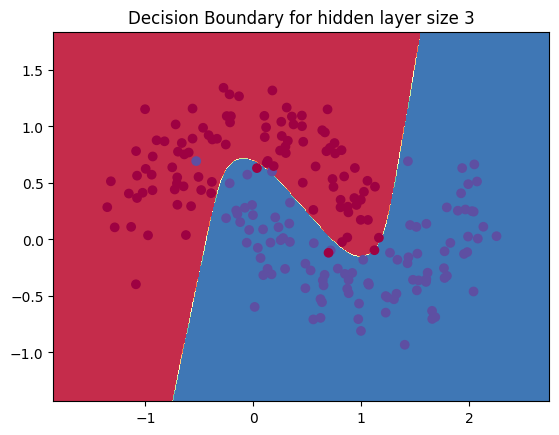

In [13]:
# 建立隐层有3个节点(神经元)的神经网络
model = build_model(3, print_loss=True)
 
# 然后再把决策/判定边界画出来
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")
plt.show()

### 咱们看到这样一个图，隐层有3个节点的神经网络能够区分得还不错
![](http://d3kbpzbmcynnmx.cloudfront.net/wp-content/uploads/2015/09/nn-from-scratch-h3.png)

In [8]:
# 然后听闻你想知道不同的隐层节点个数对结果的影响？
# 那咱们来一起看看吧
plt.figure(figsize=(16, 32))
# 设定不同的隐层节点(神经元)个数
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20, 50]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model(nn_hdim)
    plot_decision_boundary(lambda x: predict(model, x))
plt.show()

### 结果差不多是这个样子的
![](http://d3kbpzbmcynnmx.cloudfront.net/wp-content/uploads/2015/09/nn-from-scratch-hidden-layer-varying.png)